In [1]:
!pip install speechbrain torchaudio torch pinecone

In [2]:
import os
import numpy as np
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import pinecone
import uuid
from typing import List, Union, Dict, Any

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
/tmp/ipython-input-2-7160307.py:5: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


In [3]:
PINECONE_API_KEY = "pcsk_2yzKnb_DusX4M95CU1KTjQxkZFPdYWbtFghFc7kUD2cHzpUT4hWPLmMbPgEgT5NgoX3Fib"
PINECONE_ENV = "us-east-1"
INDEX_NAME = "voice-biometrics"
EMBEDDING_DIM = 192  # Matches ECAPA-TDNN output (spkrec-ecapa-voxceleb)
UPSERT_BATCH_SIZE = 100

In [4]:
def audio_to_embedding(audio_path):
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")

    try:
        # Load the pretrained model
        model = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-ecapa-voxceleb",
            savedir="pretrained_models/spkrec-ecapa-voxceleb"
        )

        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample to 16kHz if necessary
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        # Pad audio if shorter than 1 second
        min_length = 16000
        if waveform.shape[1] < min_length:
            padding = min_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Generate embedding
        embedding = model.encode_batch(waveform)

        return embedding.squeeze().numpy()

    except Exception as e:
        raise RuntimeError(f"Error processing audio: {str(e)}")

In [5]:
def test_embedding(embedding, file_name=""):
    print(f"\n=== TEST: {file_name} ===")
    print(f"Type: {type(embedding)}")
    print(f"Shape: {embedding.shape}")
    print(f"Min: {embedding.min():.4f}, Max: {embedding.max():.4f}, Mean: {embedding.mean():.4f}, Std: {embedding.std():.4f}")
    print("First 5:", embedding[:5], "... Last 5:", embedding[-5:])

    if isinstance(embedding, np.ndarray) and embedding.ndim == 1 and embedding.shape[0] > 0:
        print("✓ Valid embedding")
    else:
        print("✗ Invalid embedding")

In [6]:
from pinecone import Pinecone, ServerlessSpec

def init_pinecone():
    pc = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)

    existing_indexes = pc.list_indexes().names()
    if INDEX_NAME in existing_indexes:
        index_description = pc.describe_index(INDEX_NAME)
        if index_description.dimension != EMBEDDING_DIM:
            print(f"Index '{INDEX_NAME}' exists with dimension {index_description.dimension}, but {EMBEDDING_DIM} is required. Deleting and recreating...")

            # Delete the whole index here via the client, NOT via the Index object
            pc.delete_index(INDEX_NAME)

            print(f"Deleted index '{INDEX_NAME}'.")
            pc.create_index(
                name=INDEX_NAME,
                dimension=EMBEDDING_DIM,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-west-2")
            )
            print(f"Index '{INDEX_NAME}' created with dimension {EMBEDDING_DIM}.")
        else:
            print(f"Index '{INDEX_NAME}' already exists with correct dimension ({EMBEDDING_DIM}).")
    else:
        print(f"Index '{INDEX_NAME}' not found. Creating index...")
        pc.create_index(
            name=INDEX_NAME,
            dimension=EMBEDDING_DIM,
            metric="cosine",
            spec=ServerlessSpec(cloud="aws", region="us-west-2")
        )
        print(f"Index '{INDEX_NAME}' created with dimension {EMBEDDING_DIM}.")

    # Return the Index object for query/upsert operations
    return pc.Index(INDEX_NAME)


In [7]:
def format_embeddings(vectors: List[np.ndarray], ids: List[str], metadata_list: List[dict] = None):
    formatted = []
    for i, vec in enumerate(vectors):
        vec_id = ids[i]
        vec_data = vec.tolist()
        metadata = metadata_list[i] if metadata_list else None
        formatted.append((vec_id, vec_data, metadata) if metadata else (vec_id, vec_data))
    return formatted

In [8]:
import time
from typing import List, Union, Dict, Tuple

def batch_upsert(index, data: List[Tuple[str, List[float], Dict]], batch_size: int = 100):
    total = len(data)
    try:
        for i in range(0, total, batch_size):
            batch = data[i:i + batch_size]
            index.upsert(vectors=batch)
            print(f"✅ Upserted batch {i // batch_size + 1}: {len(batch)} vectors")
            time.sleep(0.1)  # optional: avoid hitting rate limits
    except Exception as e:
        raise RuntimeError(f"Error upserting vectors: {str(e)}")


In [9]:
import uuid

def process_audio_directory(directory_path, max_files=None):
    embeddings = []
    ids = []
    metadata_list = []

    # Initialize Pinecone index
    index = init_pinecone()
    print("🔍 Scanning for audio files...")

    files_processed = 0
    for file_name in os.listdir(directory_path):
        if max_files is not None and files_processed >= max_files:
            break  # Stop processing after max_files

        if file_name.lower().endswith((".wav", ".mp3")):
            file_path = os.path.join(directory_path, file_name)
            try:
                embedding = audio_to_embedding(file_path)
                test_embedding(embedding, file_name)

                embeddings.append(embedding)
                ids.append(str(uuid.uuid4()))
                metadata_list.append({"file_name": file_name, "source": "audio-directory"})

                files_processed += 1
            except Exception as e:
                print(f"❌ Skipping {file_name}: {e}")

    if embeddings:
        # Batch upsert to Pinecone (you can keep your batch size as is)
        formatted = [(ids[i], embeddings[i].tolist(), metadata_list[i]) for i in range(len(ids))]
        batch_upsert(index, formatted, batch_size=50)
        print(f"\n🎉 Finished processing {files_processed} audio files.")
    else:
        print("\n⚠️ No valid audio files processed.")


In [10]:
!pip install --quiet gdown pydub
from pydub import AudioSegment
import gdown
import os


In [11]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
zip_path = '/content/drive/MyDrive/recordings.zip'
extract_to = '/content/audio_samples'

import zipfile
import os

if os.path.exists(zip_path):
    print(f"Extracting {zip_path} to {extract_to} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction completed.")
else:
    print(f"ZIP file not found at {zip_path}")


Extracting /content/drive/MyDrive/recordings.zip to /content/audio_samples ...
Extraction completed.


In [13]:
# Process only first 10 audio files
process_audio_directory('/content/audio_samples/recordings', max_files=30)



INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Index 'voice-biometrics' already exists with correct dimension (192).
🔍 Scanning for audio files...


hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/hyperparams.yaml' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint sa

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt' -> '/content/pretrained_models/spkrec-ecapa-voxceleb/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /content/pretrained_models/spkrec-ecapa-voxceleb/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from l


=== TEST: english199.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -59.2608, Max: 43.4829, Mean: -0.0165, Std: 17.3517
First 5: [17.854893   8.451977   6.153543  14.354046   1.8658133] ... Last 5: [-59.26085     24.199493   -13.851551   -16.102324     0.07102492]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: khmer4.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -60.2633, Max: 59.3400, Mean: -1.6003, Std: 21.0949
First 5: [  6.7994084 -18.796041    7.402333    6.875214  -43.67122  ] ... Last 5: [30.867355    0.71409726  0.6647967   4.7376175   3.8726041 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english404.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -42.0135, Max: 66.7952, Mean: 3.0585, Std: 21.0064
First 5: [13.362371 23.802473 23.825243 10.223953 14.022429] ... Last 5: [-29.674139  -16.319073   42.01821     1.7482523  12.389578 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: mandarin18.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -53.5084, Max: 46.7289, Mean: -1.0802, Std: 20.8649
First 5: [ 12.556095     0.5649174   -3.241568     0.68915224 -27.621     ] ... Last 5: [-30.615284   -0.5203147 -18.958332  -13.766953   10.306737 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english134.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.8361, Max: 53.6946, Mean: -1.6177, Std: 18.6204
First 5: [-28.901312  23.326307 -11.705966  -9.060722  30.010073] ... Last 5: [-11.848979    3.6020613 -14.073323    1.0932404 -38.507935 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: cantonese11.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.4125, Max: 55.6407, Mean: 0.0741, Std: 21.7031
First 5: [-0.9701049 23.693567  16.120325  26.499271  15.5856905] ... Last 5: [ -3.9451144  15.540526  -21.531511    9.063796    7.5698867]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: korean25.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -73.3015, Max: 52.9542, Mean: -2.2505, Std: 20.7414
First 5: [ 52.954193 -17.929306  -4.394458 -15.993324  -2.337157] ... Last 5: [  6.993047   -8.886919   -6.0426126 -10.75074   -10.133533 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: korean16.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -65.0084, Max: 56.9357, Mean: -0.5209, Std: 22.3352
First 5: [ 31.833296 -32.086117 -28.937494  -9.852175 -29.105724] ... Last 5: [  9.533748   -8.241367    4.207255  -15.608441    6.2016034]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: polish5.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -37.9901, Max: 42.8493, Mean: -0.5610, Std: 16.0430
First 5: [ -1.5038302 -17.261566   18.423903  -12.523537   12.755057 ] ... Last 5: [-28.899263   13.965494    0.6275724  15.815471   -7.1971354]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: japanese27.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -46.4152, Max: 48.0244, Mean: 0.2535, Std: 18.0171
First 5: [ 20.14045   48.02443  -17.657324   4.035659  30.617262] ... Last 5: [ 4.0163245  7.4276657  3.9172375 12.28995   12.935128 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english63.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -64.6048, Max: 43.7443, Mean: -0.7664, Std: 20.2602
First 5: [  2.6611292  13.185996  -14.589941   35.20275    16.138758 ] ... Last 5: [-11.210925   -5.229121  -64.604836  -13.0956745   8.881642 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: japanese11.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -57.6283, Max: 75.5793, Mean: 0.7606, Std: 19.8784
First 5: [ 14.785054  -16.815722  -16.9325    -20.237646    4.8846655] ... Last 5: [25.484951 26.54406  16.93182   2.081506 26.210932]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english491.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -39.1818, Max: 41.9543, Mean: -1.6422, Std: 17.9018
First 5: [  0.0999711    2.979193     8.579483     0.07340384 -11.579807  ] ... Last 5: [ 24.850016  -13.269757   10.652095  -16.868074   -0.9141459]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: arabic7.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -49.7633, Max: 52.4618, Mean: 0.5490, Std: 20.1316
First 5: [ 29.46878    24.189577    2.3767395  22.902615  -14.446781 ] ... Last 5: [  3.7207866   -6.0703173  -12.36134      0.09954673 -17.5278    ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: kurdish2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -64.5768, Max: 48.8027, Mean: -2.3912, Std: 20.2057
First 5: [-64.5768     19.903177  -28.593332  -18.482225    7.1708145] ... Last 5: [-13.641382   16.249601  -24.378174   -3.4611056  41.426434 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english157.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.5685, Max: 39.5216, Mean: -0.2932, Std: 17.4160
First 5: [ -0.8960263   1.4359025  -3.821042  -27.992744   14.286788 ] ... Last 5: [-24.550652   10.69318    -7.73306   -15.108674    6.2482023]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: tagalog16.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -45.4314, Max: 62.9226, Mean: -2.8272, Std: 20.1427
First 5: [ 12.440085   8.391257 -35.55996   14.824114 -14.844809] ... Last 5: [-32.570576  17.568754   4.604481 -12.473501  -9.466767]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: spanish42.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -63.5279, Max: 50.6409, Mean: -0.5380, Std: 18.2527
First 5: [ -2.599575   -3.19672     1.2723185 -29.563843  -12.587567 ] ... Last 5: [ 12.237852   17.818066  -10.019398    0.3933117  -8.469195 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: temne1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -45.3579, Max: 54.8196, Mean: -0.2401, Std: 17.1681
First 5: [-13.023204  -8.566781 -14.021644 -14.356453 -27.418402] ... Last 5: [-28.732443   -0.7784667  -7.0726533  13.3012705  -4.936543 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: spanish87.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -63.5172, Max: 56.0213, Mean: -1.3578, Std: 20.6843
First 5: [-13.667412    4.9513645  23.043509    8.752695  -12.127162 ] ... Last 5: [42.04689    8.182189   9.299425  -7.672416  -5.9529433]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: arabic30.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -66.6157, Max: 57.9147, Mean: 0.1674, Std: 21.0407
First 5: [-10.957437  38.483833 -19.435804  34.307426   4.410351] ... Last 5: [-25.650618 -13.618202 -22.233818  -3.515817  15.180735]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: french49.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.8719, Max: 69.7120, Mean: -2.1338, Std: 18.4438
First 5: [ 11.369811   13.7811575  20.158342    1.7421417 -24.740013 ] ... Last 5: [ 33.843155 -18.1492    10.877995 -10.56095  -22.21377 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: gujarati7.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -63.3929, Max: 50.8518, Mean: -0.7542, Std: 19.6890
First 5: [ 0.700362 -7.048936 29.641815 28.292053 21.056982] ... Last 5: [ 25.994942  16.254612  -2.083362 -28.789513   9.873562]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english465.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -44.0932, Max: 43.4629, Mean: -0.6555, Std: 17.7849
First 5: [-22.587223   -6.5776644  -4.6721163   5.1080303 -16.121763 ] ... Last 5: [ 1.7669448 -4.374941  22.793356  -6.15998    1.4640626]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: kikuyu4.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.7864, Max: 56.0295, Mean: 1.8062, Std: 19.0541
First 5: [ -4.597172  -20.463606    2.9933257 -13.882158   -9.203254 ] ... Last 5: [  1.3719288 -43.245403   30.90518    34.614872  -15.294955 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english125.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -44.6642, Max: 57.2772, Mean: -0.0168, Std: 15.7105
First 5: [  2.592597  -13.468215    7.300729   -4.232001   -1.8324623] ... Last 5: [38.557022  -1.7234128 -2.7753203 -1.0033542 10.427348 ]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: russian33.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -57.8504, Max: 60.3576, Mean: -2.5583, Std: 19.8791
First 5: [  7.5706706 -20.07036    11.406541   16.078327   26.828667 ] ... Last 5: [-13.916654    9.670766   16.874744  -16.48271     1.1395553]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: english26.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.0641, Max: 55.2015, Mean: -2.0465, Std: 20.5014
First 5: [  7.007789 -29.432577 -37.33018    4.089715 -40.02392 ] ... Last 5: [  9.805706  -24.367012    1.5457807   8.135001   -2.1092858]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: indonesian2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -45.0850, Max: 50.4805, Mean: 0.5122, Std: 16.2014
First 5: [ 5.290296   20.71343    -0.63193023  5.187776    1.1972084 ] ... Last 5: [  9.648211  -5.463302  -7.53072  -14.268385   9.351772]
✓ Valid embedding


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: russian35.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -43.1767, Max: 54.5233, Mean: 0.4296, Std: 17.4558
First 5: [  5.842859 -11.817128  -7.788739  11.362616 -14.573314] ... Last 5: [  4.554598    -0.8333868  -17.967936    26.13155      0.14508489]
✓ Valid embedding
✅ Upserted batch 1: 30 vectors

🎉 Finished processing 30 audio files.


In [14]:
def similarity_search(audio_path: str, index, top_k: int = 5) -> Dict[str, Any]:
    """
    Perform similarity search using an audio file's embedding.

    Args:
        audio_path (str): Path to the audio file.
        index: Pinecone index object.
        top_k (int): Number of top similar results to return.

    Returns:
        Dict containing query results with IDs, scores, and metadata.
    """
    try:
        # Generate embedding for the query audio
        query_embedding = audio_to_embedding(audio_path)
        test_embedding(query_embedding, os.path.basename(audio_path))

        # Perform similarity search
        query_results = index.query(
            vector=query_embedding.tolist(),
            top_k=top_k,
            include_metadata=True
        )

        return query_results

    except Exception as e:
        raise RuntimeError(f"Error performing similarity search: {str(e)}")

In [15]:
def test_similarity_search(audio_path: str, index, top_k: int = 5):
    """
    Test similarity search for a given audio file and display results.

    Args:
        audio_path (str): Path to the query audio file.
        index: Pinecone index object.
        top_k (int): Number of top similar results to display.
    """
    print(f"\n=== Testing Similarity Search for {os.path.basename(audio_path)} ===\n")

    try:
        # Perform similarity search
        results = similarity_search(audio_path, index, top_k)

        # Check if results are valid
        if not results.get('matches'):
            print("⚠️ No matches found.")
            return

        # Display results
        print(f"Top {top_k} similar audio files:")
        for i, match in enumerate(results['matches'], 1):
            score = match['score']
            metadata = match.get('metadata', {})
            file_name = metadata.get('file_name', 'Unknown')
            print(f"{i}. ID: {match['id']}, File: {file_name}, Similarity Score: {score:.4f}")

        # Validate results
        if len(results['matches']) <= top_k:
            print("\n✓ Valid search results")
        else:
            print("\n✗ Unexpected number of results")

    except Exception as e:
        print(f"❌ Error in similarity search: {str(e)}")

In [18]:
import os

recordings_dir = "/content/audio_samples/recordings"
index = init_pinecone()  # already initialized
similarity_results = []

# List and sort audio files (optional for consistency)
audio_files = sorted([
    f for f in os.listdir(recordings_dir)
    if f.lower().endswith((".wav", ".mp3", ".flac", ".m4a", ".mp4"))
])

# Limit to first 30 as the audio files are alot to process at one and computaionally expensive.
for filename in audio_files[:30]:
    file_path = os.path.join(recordings_dir, filename)
    print(f"\n🔍 Running similarity search for: {filename}")
    try:
        result = similarity_search(file_path, index, top_k=5)
        similarity_results.append({
            "query": filename,
            "matches": result['matches']
        })
    except Exception as e:
        print(f"❌ Failed on {filename}: {e}")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Index 'voice-biometrics' already exists with correct dimension (192).

🔍 Running similarity search for: afrikaans1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.0676, Max: 57.8613, Mean: 1.1527, Std: 20.0765
First 5: [17.663769 10.902989 10.842492  3.044682 19.551695] ... Last 5: [-6.519069   9.768904   3.6892493 23.141161   6.226512 ]
✓ Valid embedding


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached



🔍 Running similarity search for: afrikaans1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.0563, Max: 57.8200, Mean: 1.1518, Std: 20.0757
First 5: [17.674194  10.890278  10.834266   3.0380063 19.551361 ] ... Last 5: [-6.510953  9.774704  3.6739   23.136612  6.23577 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans2.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans2.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.2523, Max: 83.1606, Mean: 2.1337, Std: 19.6507
First 5: [ 31.93015   32.807102  35.981197  32.01264  -19.2306  ] ... Last 5: [ 3.5243845  0.5989189 36.079514  -6.898019  -4.207625 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans2.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -56.2589, Max: 83.1600, Mean: 2.1334, Std: 19.6505
First 5: [ 31.93746   32.80924   35.98194   32.00517  -19.226603] ... Last 5: [ 3.5197554  0.5905428 36.079433  -6.9028788 -4.216663 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans3.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans3.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4272, Max: 35.8866, Mean: -1.6132, Std: 15.6091
First 5: [  6.15045     3.125396    6.08226     3.4152932 -21.083483 ] ... Last 5: [  2.5455036   1.2250605 -13.309055  -37.31365    17.482754 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans3.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans3.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4372, Max: 35.8954, Mean: -1.6141, Std: 15.6125
First 5: [  6.1440415   3.1200092   6.092802    3.4202614 -21.081121 ] ... Last 5: [  2.5453527   1.2117972 -13.311184  -37.29955    17.478636 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans4.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans4.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.8160, Max: 46.9274, Mean: -2.7798, Std: 19.4879
First 5: [ 22.096794  -19.25049     1.7266496  46.927372  -27.72102  ] ... Last 5: [-27.039263 -58.81601  -23.908642  -5.696678  10.226018]
✓ Valid embedding

🔍 Running similarity search for: afrikaans4.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans4.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.8026, Max: 46.9229, Mean: -2.7796, Std: 19.4860
First 5: [ 22.076424  -19.239256    1.7234322  46.92289   -27.708727 ] ... Last 5: [-27.051886  -58.802578  -23.898914   -5.6872463  10.225808 ]
✓ Valid embedding

🔍 Running similarity search for: afrikaans5.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans5.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -52.3740, Max: 46.7277, Mean: 0.3285, Std: 17.8222
First 5: [  4.0281415 -17.34604     7.7101717  17.660152   -4.8950014] ... Last 5: [-43.557793 -13.899024 -31.737448  10.211574  10.457313]
✓ Valid embedding

🔍 Running similarity search for: afrikaans5.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: afrikaans5.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -52.3487, Max: 46.7484, Mean: 0.3298, Std: 17.8229
First 5: [  4.0262294 -17.356726    7.7088385  17.67902    -4.885952 ] ... Last 5: [-43.52169  -13.867701 -31.719196  10.214553  10.434438]
✓ Valid embedding

🔍 Running similarity search for: agni1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: agni1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -48.2544, Max: 59.5616, Mean: 0.3200, Std: 20.2415
First 5: [  0.92676574  -3.9133966  -14.03034    -27.570244    -6.439922  ] ... Last 5: [-12.105611  40.605305 -34.737915 -15.412992  -8.202853]
✓ Valid embedding

🔍 Running similarity search for: agni1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: agni1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -48.2691, Max: 59.5638, Mean: 0.3199, Std: 20.2420
First 5: [  0.91611415  -3.9316123  -14.034635   -27.581024    -6.4513307 ] ... Last 5: [-12.106102  40.600994 -34.744514 -15.393249  -8.210694]
✓ Valid embedding

🔍 Running similarity search for: akan1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: akan1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -54.2919, Max: 53.5073, Mean: -0.6807, Std: 22.3125
First 5: [  6.31687   -13.633967    3.7689924  50.25975   -15.995572 ] ... Last 5: [-30.204456   16.388325    8.5044565  17.480871   41.307526 ]
✓ Valid embedding

🔍 Running similarity search for: akan1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: akan1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -54.2882, Max: 53.5169, Mean: -0.6804, Std: 22.3117
First 5: [  6.324179  -13.633571    3.7724783  50.252274  -15.991771 ] ... Last 5: [-30.203455  16.3831     8.503229  17.485388  41.3023  ]
✓ Valid embedding

🔍 Running similarity search for: albanian1.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian1.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3475, Max: 47.5914, Mean: -0.4579, Std: 19.1071
First 5: [ 12.971375 -12.627606 -26.124205   3.626316 -10.046548] ... Last 5: [-17.292965  -21.790798   -9.990725    4.9251323 -21.82954  ]
✓ Valid embedding

🔍 Running similarity search for: albanian1.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian1.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3534, Max: 47.6115, Mean: -0.4580, Std: 19.1093
First 5: [ 12.979201  -12.629129  -26.13082     3.6290557 -10.060806 ] ... Last 5: [-17.323412 -21.771225  -9.971919   4.917106 -21.831068]
✓ Valid embedding

🔍 Running similarity search for: albanian2.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian2.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -71.5144, Max: 59.9613, Mean: -1.6611, Std: 18.6514
First 5: [  2.4735787 -12.354555  -17.549208   25.21481    -1.6533339] ... Last 5: [ 19.042963 -36.76617  -32.42167   -7.83557  -24.303045]
✓ Valid embedding

🔍 Running similarity search for: albanian2.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian2.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -71.5157, Max: 59.9624, Mean: -1.6598, Std: 18.6526
First 5: [  2.479781 -12.371361 -17.538515  25.22141   -1.646554] ... Last 5: [ 19.047468 -36.76221  -32.415443  -7.821243 -24.294996]
✓ Valid embedding

🔍 Running similarity search for: albanian3.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian3.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3318, Max: 51.6668, Mean: -0.3461, Std: 20.0591
First 5: [-18.677979   -6.9530826   8.354387  -24.238806  -26.9773   ] ... Last 5: [ 22.783531   26.757671   17.099476   -3.4635959 -29.107697 ]
✓ Valid embedding

🔍 Running similarity search for: albanian3.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian3.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.3109, Max: 51.6329, Mean: -0.3470, Std: 20.0563
First 5: [-18.68638   -6.946879   8.349669 -24.238565 -26.96606 ] ... Last 5: [ 22.782412  26.738596  17.102991  -3.470277 -29.093847]
✓ Valid embedding

🔍 Running similarity search for: albanian4.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian4.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.5179, Max: 42.4219, Mean: -1.6459, Std: 17.8214
First 5: [-13.715524   -7.8301597   9.127169    3.8650913  20.481852 ] ... Last 5: [ 38.97351  -35.85507  -12.123476 -10.049852 -23.421091]
✓ Valid embedding

🔍 Running similarity search for: albanian4.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian4.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -51.5043, Max: 42.4178, Mean: -1.6444, Std: 17.8210
First 5: [-13.721476   -7.835946    9.14024     3.8748882  20.476755 ] ... Last 5: [ 38.96721  -35.859222 -12.14468  -10.053564 -23.427607]
✓ Valid embedding

🔍 Running similarity search for: albanian5.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian5.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4241, Max: 56.3537, Mean: -2.0409, Std: 21.2815
First 5: [-24.726597   -4.160841  -11.344291   37.444077   -2.9259162] ... Last 5: [-24.320995 -24.925552  25.273678  15.684905  -6.671187]
✓ Valid embedding

🔍 Running similarity search for: albanian5.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian5.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -58.4233, Max: 56.3433, Mean: -2.0412, Std: 21.2810
First 5: [-24.724653   -4.162956  -11.349726   37.43927    -2.9314523] ... Last 5: [-24.304403 -24.924564  25.273071  15.69595   -6.673924]
✓ Valid embedding

🔍 Running similarity search for: albanian6.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian6.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -43.1611, Max: 37.4313, Mean: 0.5191, Std: 16.5101
First 5: [-8.658733   23.939455    2.9978514  12.484951    0.97929096] ... Last 5: [  5.9101653  -31.059053    -2.255481    25.42669      0.35809293]
✓ Valid embedding

🔍 Running similarity search for: albanian6.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian6.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -43.1478, Max: 37.4230, Mean: 0.5185, Std: 16.5078
First 5: [-8.670228  23.950653   2.9752269 12.53367    0.9769039] ... Last 5: [  5.915449  -31.042841   -2.2878764  25.43231     0.3406655]
✓ Valid embedding

🔍 Running similarity search for: albanian7.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian7.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -62.8227, Max: 45.5626, Mean: -1.2302, Std: 19.5184
First 5: [13.233957  -9.061053  -7.2841697  8.888069  12.419831 ] ... Last 5: [ -4.117674 -36.232857 -20.612558 -36.293453  15.490036]
✓ Valid embedding

🔍 Running similarity search for: albanian7.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian7.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -62.8141, Max: 45.5598, Mean: -1.2288, Std: 19.5179
First 5: [13.227481  -9.06573   -7.2902856  8.887268  12.421828 ] ... Last 5: [ -4.1094694 -36.217606  -20.584938  -36.275555   15.510966 ]
✓ Valid embedding

🔍 Running similarity search for: albanian8.mp3


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian8.mp3 ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.4319, Max: 46.0269, Mean: -3.3525, Std: 18.4579
First 5: [  5.0927386  -7.2102127 -12.235314    7.280247  -19.139801 ] ... Last 5: [-43.075775  -29.191141  -12.627066    5.4801474 -14.269547 ]
✓ Valid embedding

🔍 Running similarity search for: albanian8.wav


DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["clas


=== TEST: albanian8.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.4467, Max: 46.0348, Mean: -3.3539, Std: 18.4590
First 5: [  5.0958557  -7.2171574 -12.234979    7.2812347 -19.133385 ] ... Last 5: [-43.070652  -29.201786  -12.638655    5.4795055 -14.280348 ]
✓ Valid embedding


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/spkrec-ecapa-voxceleb.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/pretrained_models/spkrec-ecapa-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/pretrained_models/spkrec-ecapa-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/pretraine


=== TEST: albanian8.wav ===
Type: <class 'numpy.ndarray'>
Shape: (192,)
Min: -61.4467, Max: 46.0348, Mean: -3.3539, Std: 18.4590
First 5: [  5.0958557  -7.2171574 -12.234979    7.2812347 -19.133385 ] ... Last 5: [-43.070652  -29.201786  -12.638655    5.4795055 -14.280348 ]
✓ Valid embedding


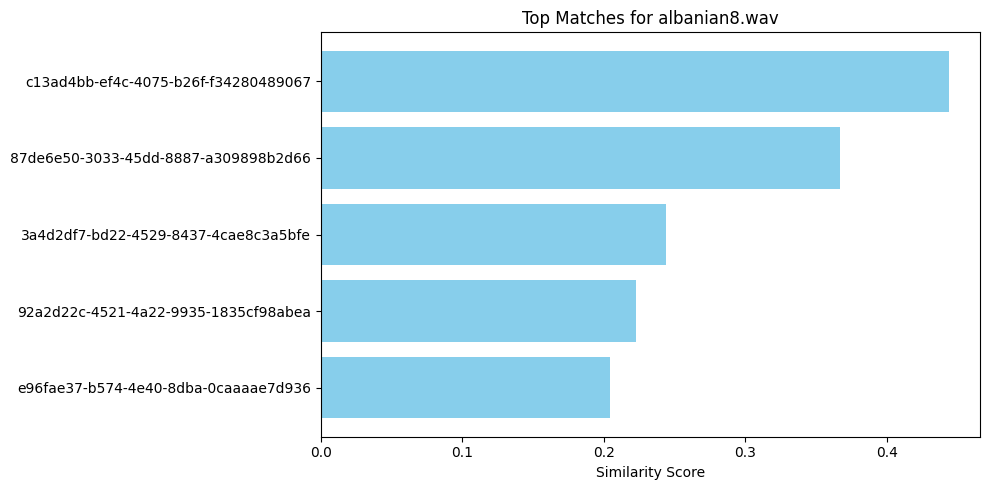

In [20]:
import matplotlib.pyplot as plt

def plot_similarity_scores(query_file: str, matches: list):
    ids = [match['id'] for match in matches]
    scores = [match['score'] for match in matches]

    plt.figure(figsize=(10, 5))
    plt.barh(ids[::-1], scores[::-1], color='skyblue')
    plt.xlabel("Similarity Score")
    plt.title(f"Top Matches for {query_file}")
    plt.tight_layout()
    plt.show()
results = similarity_search(file_path, index, top_k=5)
plot_similarity_scores(filename, results['matches'])


In [21]:
from sklearn.decomposition import PCA
import numpy as np

def visualize_embeddings(embeddings, labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, perplexity=10)

    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
    plt.title("2D Projection of Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def interactive_visualize_embeddings(embeddings, labels, method='pca'):
    """
    Interactive 2D visualization of audio embeddings using PCA or t-SNE.

    Args:
        embeddings (ndarray): Numpy array of shape (n_samples, n_features).
        labels (list): List of file names or labels.
        method (str): 'pca' or 'tsne' for dimensionality reduction.
    """
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=5, random_state=42)
    else:
        raise ValueError("Method must be either 'pca' or 'tsne'.")

    reduced = reducer.fit_transform(embeddings)

    fig = px.scatter(
        x=reduced[:, 0],
        y=reduced[:, 1],
        text=labels,
        labels={'x': 'Component 1', 'y': 'Component 2'},
        title=f'2D Visualization of Audio Embeddings using {method.upper()}',
        hover_name=labels,
    )
    fig.update_traces(marker=dict(size=8, color='blue'), textposition='top center')
    fig.update_layout(showlegend=False)
    fig.show()
interactive_visualize_embeddings(np.array(all_embeddings), labels, method='pca')


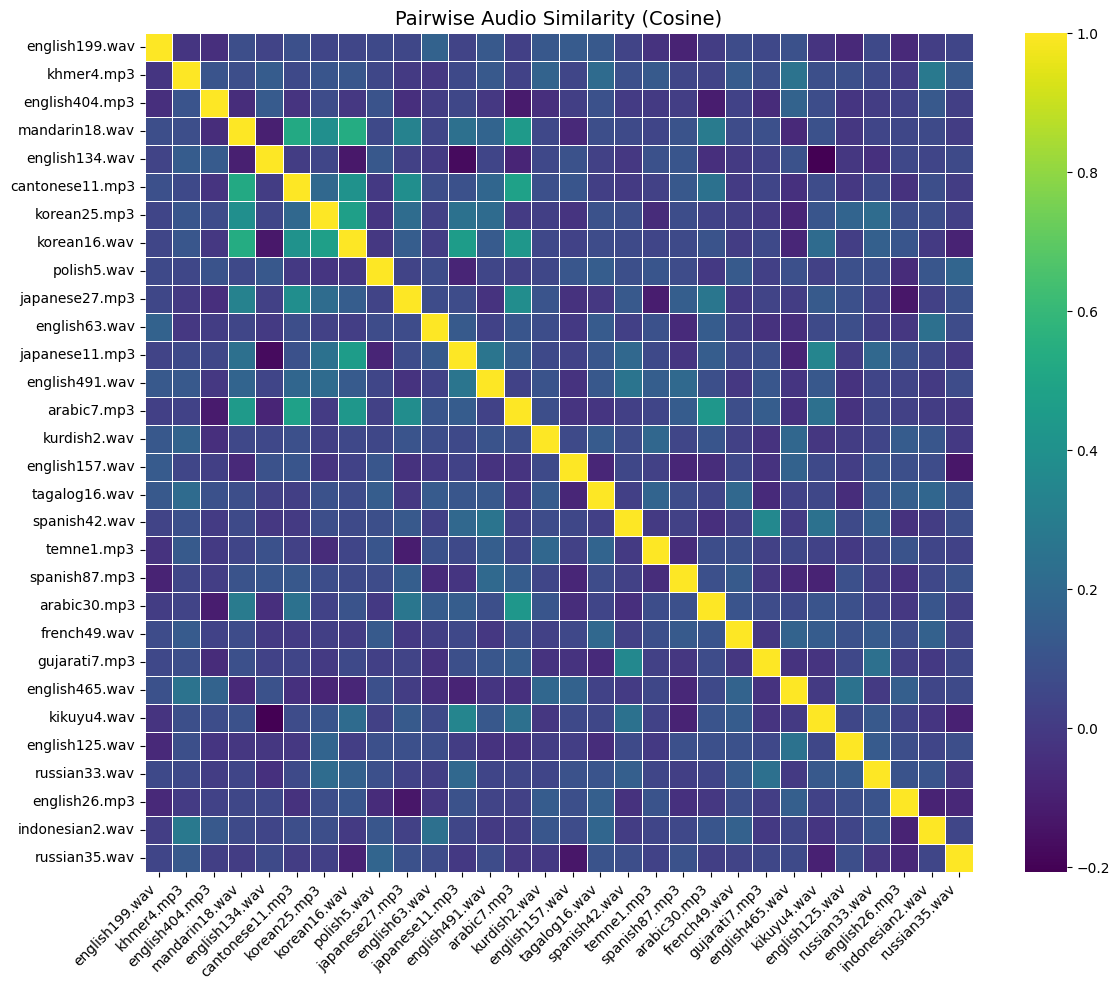

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity_matrix(embeddings, labels, max_labels=30):
    """
    Plot a heatmap of cosine similarity between audio embeddings.

    Args:
        embeddings (ndarray): Array of shape (n_samples, embedding_dim).
        labels (list): List of filenames/labels.
        max_labels (int): Truncate to avoid overcrowding. Default = 30.
    """
    # Truncate if there are too many items
    if len(labels) > max_labels:
        embeddings = embeddings[:max_labels]
        labels = labels[:max_labels]

    # Compute cosine similarity
    sim_matrix = cosine_similarity(embeddings)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels,
                cmap='viridis', annot=False, linewidths=0.5)
    plt.title("Pairwise Audio Similarity (Cosine)", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
plot_similarity_matrix(np.array(all_embeddings), labels)
